In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
from abc import abstractmethod
from einops import repeat
from functools import partial
from inspect import isfunction

In [24]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [25]:
datapath = "../../../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [26]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [27]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [28]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [29]:
from sklearn.model_selection import train_test_split 

def prepare_data(features):
    sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])
    features_scaled = features_scaled[sensor_columns + ['activity']]
    
    print("columns : ", features_scaled.columns)
    
    # 1. ADL과 Fall 데이터 분리
    adl_mask = features_scaled['activity'] == 0
    adl_data = features_scaled[adl_mask]
    
    fall_mask = features_scaled['activity'] == 1
    fall_data = features_scaled[fall_mask]
    
    # 2. Window 기반 시계열 데이터 생성
    adl_sequences, adl_labels = split_sequences(adl_data, WINDOW_LENGTH, STRIDE)
    fall_sequences, fall_labels = split_sequences(fall_data, WINDOW_LENGTH, STRIDE)
    
    print(f"ADL sequences shape: {adl_sequences.shape}")
    print(f"Fall sequences shape: {fall_sequences.shape}")
    
    # 3. 훈련/테스트 데이터 분할
    # ADL 데이터: 80%는 훈련용, 20%는 테스트용
    adl_train_data, adl_test_data, adl_train_labels, adl_test_labels = train_test_split(
        adl_sequences, adl_labels, test_size=0.2, random_state=42
    )
    
    # Fall 데이터: 모두 테스트용 (또는 훈련/테스트로 분할 가능)
    # 여기서는 모든 Fall 데이터를 테스트용으로 사용
    # 필요에 따라 아래 주석을 해제하여 Fall 데이터도 훈련/테스트로 분할 가능
    """
    fall_train_data, fall_test_data, fall_train_labels, fall_test_labels = train_test_split(
        fall_sequences, fall_labels, test_size=0.2, random_state=42
    )
    """
    fall_test_data = fall_sequences
    fall_test_labels = fall_labels
    
    # 4. 최종 데이터셋 구성
    # 훈련 데이터: ADL의 훈련 부분만 사용
    train_data = adl_train_data
    train_labels = adl_train_labels
    
    # 테스트 데이터: ADL의 테스트 부분과 Fall 데이터 분리
    test_adl_data = adl_test_data
    test_adl_labels = adl_test_labels
    
    # Fall 데이터를 두 부분으로 나누기 (fall1, fall2)
    # 여기서는 간단히 절반으로 나눕니다
    split_idx = len(fall_test_data) // 2
    test_fall1_data = fall_test_data[:split_idx]
    test_fall1_labels = fall_test_labels[:split_idx]
    test_fall2_data = fall_test_data[split_idx:]
    test_fall2_labels = fall_test_labels[split_idx:]
    
    print(f"Train data shape: {train_data.shape}")
    print(f"Test ADL data shape: {test_adl_data.shape}")
    print(f"Test Fall1 data shape: {test_fall1_data.shape}")
    print(f"Test Fall2 data shape: {test_fall2_data.shape}")
    
    return train_data, test_adl_data, test_fall1_data, test_fall2_data

In [30]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [31]:
subject_id = 16
dfs_16 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_16.append(df)

features_16 = pd.concat(dfs_16, ignore_index=True)
features_16['activity'] = features_16['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_16 = features_16.dropna()

100%|█| 746/746 [00:00<00:00, 1246.1


In [32]:
subject_id = 17
dfs_17 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_17.append(df)

features_17 = pd.concat(dfs_17, ignore_index=True)
features_17['activity'] = features_17['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_17 = features_17.dropna()

100%|█| 746/746 [00:01<00:00, 713.00


In [33]:
subject_id = 18
dfs_18 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_18.append(df)

features_18 = pd.concat(dfs_18, ignore_index=True)
features_18['activity'] = features_18['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_18 = features_18.dropna()

100%|█| 746/746 [00:08<00:00, 88.01i


In [34]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data_16, test_adl_data_16, test_fall1_data_16, test_fall2_data_16 = prepare_data(features_16)
train_data_17, test_adl_data_17, test_fall1_data_17, test_fall2_data_17 = prepare_data(features_17)
train_data_18, test_adl_data_18, test_fall1_data_18, test_fall2_data_18 = prepare_data(features_18)

columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')
ADL sequences shape: (73, 40, 39)
Fall sequences shape: (79, 40, 39)
Train data shape: (58, 40, 39)
Test ADL data shape: (15, 40, 39)
Test Fall1 data shape: (39, 40, 39)
Test Fall2 data shape: (40, 40, 39)
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_

----

In [35]:
EPOCHS = 500
INITIAL_LEARNING_RATE = 1e-4 
DECAY_STEPS = 1000
DECAY_RATE = 0.98
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

import math
from functools import partial
from inspect import isfunction

In [36]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [37]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                    These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

In [38]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(x)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, 1)

    def forward(self, x, emb):
        return self._forward(x, emb)

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

In [39]:
class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=32,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)

In [40]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps: int = 1000,
        beta_schedule="linear",
        loss_type="l2",
        log_every_t=100,
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
        original_elbo_weight=0.0,
        v_posterior=0.0,
        l_simple_weight=1.0,
        parameterization="eps",
        learn_logvar=False,
        logvar_init=0.0,
    ):
        super().__init__()
        assert parameterization in [
            "eps",
            "x0",
        ], 'currently only supporting "eps" and "x0"'
        self.parameterization = parameterization

        self.model = UNetModel(**unet_config.get("params", dict()))

        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        self.loss_type = loss_type

        self.register_schedule(
            beta_schedule=beta_schedule,
            timesteps=timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(
            fill_value=logvar_init, size=(self.num_timesteps,)
        )
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

    def register_schedule(
        self,
        beta_schedule="linear",
        timesteps=1000,
        linear_start=1e-4,
        linear_end=2e-2,
        cosine_s=8e-3,
    ):
        betas = make_beta_schedule(
            beta_schedule,
            timesteps,
            linear_start=linear_start,
            linear_end=linear_end,
            cosine_s=cosine_s,
        )
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer(
            "alphas_cumprod_prev", to_torch(alphas_cumprod_prev)
        )

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            "sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod",
            to_torch(np.sqrt(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod",
            to_torch(np.log(1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod)),
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod",
            to_torch(np.sqrt(1.0 / alphas_cumprod - 1)),
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (
            1.0 - alphas_cumprod_prev
        ) / (1.0 - alphas_cumprod) + self.v_posterior * betas
        self.register_buffer(
            "posterior_variance", to_torch(posterior_variance)
        )
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(
                betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
            ),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev)
                * np.sqrt(alphas)
                / (1.0 - alphas_cumprod)
            ),
        )

        if self.parameterization == "eps":
            lvlb_weights = self.betas**2 / (
                2
                * self.posterior_variance
                * to_torch(alphas)
                * (1 - self.alphas_cumprod)
            )
        elif self.parameterization == "x0":
            lvlb_weights = (
                0.5
                * np.sqrt(torch.Tensor(alphas_cumprod))
                / (2.0 * 1 - torch.Tensor(alphas_cumprod))
            )
        else:
            raise NotImplementedError("mu not supported")
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer("lvlb_weights", lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of
        noiseless inputs.
        :param t: the number of diffusion steps (minus 1).
        Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance),
        all of x_start's shape.
        """
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:
            q(x_{t-1} | x_t, x_0)
        """
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return (
            posterior_mean,
            posterior_variance,
            posterior_log_variance_clipped,
        )

    def p_mean_variance(self, x, t, clip_denoised: bool, return_x0=False):
        """
        Apply the model to get p(x_{t-1} | x_t)
        :param model: the model, which takes a signal and a batch of timesteps
                    as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        """
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        (
            model_mean,
            posterior_variance,
            posterior_log_variance,
        ) = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_x0:
            return (
                model_mean,
                posterior_variance,
                posterior_log_variance,
                x_recon,
            )
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(
        self,
        x,
        t,
        clip_denoised=True,
        repeat_noise=False,
        return_x0=False,
        temperature=1.0,
        noise_dropout=0.0,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        """

        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(
            x=x,
            t=t,
            clip_denoised=clip_denoised,
            return_x0=return_x0,
        )
        if return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.0:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(
            b, *((1,) * (len(x.shape) - 1))
        )
        if return_x0:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise,
                x0,
            )
        else:
            return (
                model_mean
                + nonzero_mask * (0.5 * model_log_variance).exp() * noise
            )

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device

        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]

        for i in tqdm(
            reversed(range(0, self.num_timesteps)),
            desc="sampling loop time step",
            total=self.num_timesteps,
        ):
            img = self.p_sample(
                img,
                torch.full((b,), i, device=device, dtype=torch.long),
                clip_denoised=self.clip_denoised,
            )
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop(
            (batch_size, channels, image_size, image_size),
            return_intermediates=return_intermediates,
        )

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.
        In other words, sample from q(x_t | x_0).
        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here,
        0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == "l1":
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == "l2":
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(
                    target, pred, reduction="none"
                )
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(
                f"Paramterization {self.parameterization} not yet supported"
            )

        loss_simple = self.get_loss(model_output, target, mean=False).mean(
            dim=[1, 2]
        )
        loss_dict.update({f"loss_simple": loss_simple.mean()})

        logvar_t = self.logvar[t].to(x_start.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        if self.learn_logvar:
            loss_dict.update({f"loss_gamma": loss.mean()})
            loss_dict.update({"logvar": self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(
            dim=(1, 2)
        )
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f"loss_vlb": loss_vlb})
        loss += self.original_elbo_weight * loss_vlb
        loss_dict.update({f"loss": loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        t = torch.randint(
            0, self.num_timesteps, (x.shape[0],), device=x.device
        ).long()
        return self.p_losses(x, t, *args, **kwargs)

    def configure_optimizers(self):
        self.learning_rate = 1e-4
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            print("Diffusion model optimizing logvar")
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        return opt

In [41]:
def train_ddpm_ppg(model, train_loader, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        pbar = tqdm(enumerate(train_loader), 
                   desc=f'Epoch {epoch+1}/{num_epochs}', 
                   total=n_batches,
                   leave=False)
        
        for i, batch in pbar:
            optimizer.zero_grad()
            x = batch.to(device)
            loss, loss_dict = model(x)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [42]:
unet_config = {
    "params": {
        "image_size": 40, 
        "in_channels": 39, 
        "model_channels": 32,
        "out_channels": 39,
        "num_res_blocks": 2,
        "attention_resolutions": [10, 5],
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
        "use_scale_shift_norm": True
    }
}

ddpm1 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer1 = ddpm1.configure_optimizers()

print("\nSubject 16 Training:")
train_dataset_16 = UMAFallDataset(train_data_16)
train_loader_16 = DataLoader(train_dataset_16, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm1, train_loader_16, optimizer1, EPOCHS, device)


Subject 16 Training:


Epoch 1/500 - Avg Loss: 0.9944


Epoch 2/500 - Avg Loss: 0.9963


Epoch 3/500 - Avg Loss: 0.9935


Epoch 4/500 - Avg Loss: 0.9940


Epoch 5/500 - Avg Loss: 1.0054


Epoch 6/500 - Avg Loss: 0.9920


Epoch 7/500 - Avg Loss: 0.9858


Epoch 8/500 - Avg Loss: 0.9893


Epoch 9/500 - Avg Loss: 0.9920


Epoch 10/500 - Avg Loss: 0.9882


Epoch 11/500 - Avg Loss: 0.9790


Epoch 12/500 - Avg Loss: 0.9918


Epoch 13/500 - Avg Loss: 0.9902


Epoch 14/500 - Avg Loss: 0.9754


Epoch 15/500 - Avg Loss: 0.9681


Epoch 16/500 - Avg Loss: 0.9698


Epoch 17/500 - Avg Loss: 0.9675


Epoch 18/500 - Avg Loss: 0.9705


Epoch 19/500 - Avg Loss: 0.9640


Epoch 20/500 - Avg Loss: 0.9711


Epoch 21/500 - Avg Loss: 0.9616


Epoch 22/500 - Avg Loss: 0.9606


Epoch 23/500 - Avg Loss: 0.9546


Epoch 24/500 - Avg Loss: 0.9525


Epoch 25/500 - Avg Loss: 0.9479


Epoch 26/500 - Avg Loss: 0.9471


Epoch 27/500 - Avg Loss: 0.9587


Epoch 28/500 - Avg Loss: 0.9439


Epoch 29/500 - Avg Loss: 0.9475


Epoch 30/500 - Avg Loss: 0.9492


Epoch 31/500 - Avg Loss: 0.9338


Epoch 32/500 - Avg Loss: 0.9435


Epoch 33/500 - Avg Loss: 0.9353


Epoch 34/500 - Avg Loss: 0.9460


Epoch 35/500 - Avg Loss: 0.9409


Epoch 36/500 - Avg Loss: 0.9445


Epoch 37/500 - Avg Loss: 0.9258


Epoch 38/500 - Avg Loss: 0.9332


Epoch 39/500 - Avg Loss: 0.9190


Epoch 40/500 - Avg Loss: 0.9183


Epoch 41/500 - Avg Loss: 0.9165


Epoch 42/500 - Avg Loss: 0.9153


Epoch 43/500 - Avg Loss: 0.9111


Epoch 44/500 - Avg Loss: 0.9249


Epoch 45/500 - Avg Loss: 0.9175


Epoch 46/500 - Avg Loss: 0.9145


Epoch 47/500 - Avg Loss: 0.9101


Epoch 48/500 - Avg Loss: 0.9173


Epoch 49/500 - Avg Loss: 0.8993


Epoch 50/500 - Avg Loss: 0.9053


Epoch 51/500 - Avg Loss: 0.9037


Epoch 52/500 - Avg Loss: 0.9029


Epoch 53/500 - Avg Loss: 0.8880


Epoch 54/500 - Avg Loss: 0.9067


Epoch 55/500 - Avg Loss: 0.8960


Epoch 56/500 - Avg Loss: 0.9036


Epoch 57/500 - Avg Loss: 0.8878


Epoch 58/500 - Avg Loss: 0.8750


Epoch 59/500 - Avg Loss: 0.8829


Epoch 60/500 - Avg Loss: 0.8835


Epoch 61/500 - Avg Loss: 0.8753


Epoch 62/500 - Avg Loss: 0.8761


Epoch 63/500 - Avg Loss: 0.8856


Epoch 64/500 - Avg Loss: 0.8712


Epoch 65/500 - Avg Loss: 0.8804


Epoch 66/500 - Avg Loss: 0.8782


Epoch 67/500 - Avg Loss: 0.8839


Epoch 68/500 - Avg Loss: 0.8792


Epoch 69/500 - Avg Loss: 0.8756


Epoch 70/500 - Avg Loss: 0.8661


Epoch 71/500 - Avg Loss: 0.8533


Epoch 72/500 - Avg Loss: 0.8607


Epoch 73/500 - Avg Loss: 0.8596


Epoch 74/500 - Avg Loss: 0.8623


Epoch 75/500 - Avg Loss: 0.8576


Epoch 76/500 - Avg Loss: 0.8629


Epoch 77/500 - Avg Loss: 0.8578


Epoch 78/500 - Avg Loss: 0.8486


Epoch 79/500 - Avg Loss: 0.8554


Epoch 80/500 - Avg Loss: 0.8417


Epoch 81/500 - Avg Loss: 0.8541


Epoch 82/500 - Avg Loss: 0.8434


Epoch 83/500 - Avg Loss: 0.8541


Epoch 84/500 - Avg Loss: 0.8299


Epoch 85/500 - Avg Loss: 0.8508


Epoch 86/500 - Avg Loss: 0.8375


Epoch 87/500 - Avg Loss: 0.8374


Epoch 88/500 - Avg Loss: 0.8400


Epoch 89/500 - Avg Loss: 0.8489


Epoch 90/500 - Avg Loss: 0.8275


Epoch 91/500 - Avg Loss: 0.8284


Epoch 92/500 - Avg Loss: 0.8349


Epoch 93/500 - Avg Loss: 0.8334


Epoch 94/500 - Avg Loss: 0.8244


Epoch 95/500 - Avg Loss: 0.8216


Epoch 96/500 - Avg Loss: 0.8362


Epoch 97/500 - Avg Loss: 0.8132


Epoch 98/500 - Avg Loss: 0.8147


Epoch 99/500 - Avg Loss: 0.8246


Epoch 100/500 - Avg Loss: 0.8117


Epoch 101/500 - Avg Loss: 0.8124


Epoch 102/500 - Avg Loss: 0.8104


Epoch 103/500 - Avg Loss: 0.8167


Epoch 104/500 - Avg Loss: 0.8107


Epoch 105/500 - Avg Loss: 0.8183


Epoch 106/500 - Avg Loss: 0.8211


Epoch 107/500 - Avg Loss: 0.8040


Epoch 108/500 - Avg Loss: 0.7891


Epoch 109/500 - Avg Loss: 0.8049


Epoch 110/500 - Avg Loss: 0.7981


Epoch 111/500 - Avg Loss: 0.7946


Epoch 112/500 - Avg Loss: 0.8100


Epoch 113/500 - Avg Loss: 0.7906


Epoch 114/500 - Avg Loss: 0.7900


Epoch 115/500 - Avg Loss: 0.7988


Epoch 116/500 - Avg Loss: 0.7847


Epoch 117/500 - Avg Loss: 0.7890


Epoch 118/500 - Avg Loss: 0.7771


Epoch 119/500 - Avg Loss: 0.7763


Epoch 120/500 - Avg Loss: 0.7869


Epoch 121/500 - Avg Loss: 0.7810


Epoch 122/500 - Avg Loss: 0.7940


Epoch 123/500 - Avg Loss: 0.7686


Epoch 124/500 - Avg Loss: 0.7863


Epoch 125/500 - Avg Loss: 0.7682


Epoch 126/500 - Avg Loss: 0.7671


Epoch 127/500 - Avg Loss: 0.7880


Epoch 128/500 - Avg Loss: 0.7758


Epoch 129/500 - Avg Loss: 0.7769


Epoch 130/500 - Avg Loss: 0.7614


Epoch 131/500 - Avg Loss: 0.7788


Epoch 132/500 - Avg Loss: 0.7512


Epoch 133/500 - Avg Loss: 0.7641


Epoch 134/500 - Avg Loss: 0.7542


Epoch 135/500 - Avg Loss: 0.7577


Epoch 136/500 - Avg Loss: 0.7665


Epoch 137/500 - Avg Loss: 0.7637


Epoch 138/500 - Avg Loss: 0.7558


Epoch 139/500 - Avg Loss: 0.7461


Epoch 140/500 - Avg Loss: 0.7730


Epoch 141/500 - Avg Loss: 0.7475


Epoch 142/500 - Avg Loss: 0.7450


Epoch 143/500 - Avg Loss: 0.7524


Epoch 144/500 - Avg Loss: 0.7492


Epoch 145/500 - Avg Loss: 0.7720


Epoch 146/500 - Avg Loss: 0.7564


Epoch 147/500 - Avg Loss: 0.7392


Epoch 148/500 - Avg Loss: 0.7468


Epoch 149/500 - Avg Loss: 0.7499


Epoch 150/500 - Avg Loss: 0.7232


Epoch 151/500 - Avg Loss: 0.7416


Epoch 152/500 - Avg Loss: 0.7202


Epoch 153/500 - Avg Loss: 0.7296


Epoch 154/500 - Avg Loss: 0.7238


Epoch 155/500 - Avg Loss: 0.7459


Epoch 156/500 - Avg Loss: 0.7424


Epoch 157/500 - Avg Loss: 0.7354


Epoch 158/500 - Avg Loss: 0.7222


Epoch 159/500 - Avg Loss: 0.7310


Epoch 160/500 - Avg Loss: 0.7171


Epoch 161/500 - Avg Loss: 0.7173


Epoch 162/500 - Avg Loss: 0.7261


Epoch 163/500 - Avg Loss: 0.7296


Epoch 164/500 - Avg Loss: 0.7166


Epoch 165/500 - Avg Loss: 0.7167


Epoch 166/500 - Avg Loss: 0.7229


Epoch 167/500 - Avg Loss: 0.7092


Epoch 168/500 - Avg Loss: 0.7272


Epoch 169/500 - Avg Loss: 0.7190


Epoch 170/500 - Avg Loss: 0.7034


Epoch 171/500 - Avg Loss: 0.6905


Epoch 172/500 - Avg Loss: 0.7244


Epoch 173/500 - Avg Loss: 0.7089


Epoch 174/500 - Avg Loss: 0.7097


Epoch 175/500 - Avg Loss: 0.7018


Epoch 176/500 - Avg Loss: 0.7085


Epoch 177/500 - Avg Loss: 0.6931


Epoch 178/500 - Avg Loss: 0.7016


Epoch 179/500 - Avg Loss: 0.6863


Epoch 180/500 - Avg Loss: 0.7042


Epoch 181/500 - Avg Loss: 0.7077


Epoch 182/500 - Avg Loss: 0.6980


Epoch 183/500 - Avg Loss: 0.7009


Epoch 184/500 - Avg Loss: 0.6856


Epoch 185/500 - Avg Loss: 0.6866


Epoch 186/500 - Avg Loss: 0.6685


Epoch 187/500 - Avg Loss: 0.7106


Epoch 188/500 - Avg Loss: 0.6676


Epoch 189/500 - Avg Loss: 0.6777


Epoch 190/500 - Avg Loss: 0.6760


Epoch 191/500 - Avg Loss: 0.6819


Epoch 192/500 - Avg Loss: 0.6841


Epoch 193/500 - Avg Loss: 0.7081


Epoch 194/500 - Avg Loss: 0.6987


Epoch 195/500 - Avg Loss: 0.6556


Epoch 196/500 - Avg Loss: 0.6618


Epoch 197/500 - Avg Loss: 0.6839


Epoch 198/500 - Avg Loss: 0.6708


Epoch 199/500 - Avg Loss: 0.6849


Epoch 200/500 - Avg Loss: 0.6884


Epoch 201/500 - Avg Loss: 0.6640


Epoch 202/500 - Avg Loss: 0.6433


Epoch 203/500 - Avg Loss: 0.6799


Epoch 204/500 - Avg Loss: 0.6937


Epoch 205/500 - Avg Loss: 0.6826


Epoch 206/500 - Avg Loss: 0.6482


Epoch 207/500 - Avg Loss: 0.6713


Epoch 208/500 - Avg Loss: 0.7024


Epoch 209/500 - Avg Loss: 0.6535


Epoch 210/500 - Avg Loss: 0.6702


Epoch 211/500 - Avg Loss: 0.6633


Epoch 212/500 - Avg Loss: 0.6708


Epoch 213/500 - Avg Loss: 0.6438


Epoch 214/500 - Avg Loss: 0.6507


Epoch 215/500 - Avg Loss: 0.6670


Epoch 216/500 - Avg Loss: 0.6488


Epoch 217/500 - Avg Loss: 0.6725


Epoch 218/500 - Avg Loss: 0.6620


Epoch 219/500 - Avg Loss: 0.6649


Epoch 220/500 - Avg Loss: 0.6517


Epoch 221/500 - Avg Loss: 0.6513


Epoch 222/500 - Avg Loss: 0.6644


Epoch 223/500 - Avg Loss: 0.6612


Epoch 224/500 - Avg Loss: 0.6288


Epoch 225/500 - Avg Loss: 0.6443


Epoch 226/500 - Avg Loss: 0.6312


Epoch 227/500 - Avg Loss: 0.6688


Epoch 228/500 - Avg Loss: 0.6586


Epoch 229/500 - Avg Loss: 0.6616


Epoch 230/500 - Avg Loss: 0.6856


Epoch 231/500 - Avg Loss: 0.6752


Epoch 232/500 - Avg Loss: 0.6451


Epoch 233/500 - Avg Loss: 0.6457


Epoch 234/500 - Avg Loss: 0.6546


Epoch 235/500 - Avg Loss: 0.6277


Epoch 236/500 - Avg Loss: 0.6471


Epoch 237/500 - Avg Loss: 0.6714


Epoch 238/500 - Avg Loss: 0.6568


Epoch 239/500 - Avg Loss: 0.6541


Epoch 240/500 - Avg Loss: 0.6595


Epoch 241/500 - Avg Loss: 0.6669


Epoch 242/500 - Avg Loss: 0.6189


Epoch 243/500 - Avg Loss: 0.6289


Epoch 244/500 - Avg Loss: 0.6496


Epoch 245/500 - Avg Loss: 0.6321


Epoch 246/500 - Avg Loss: 0.6380


Epoch 247/500 - Avg Loss: 0.6220


Epoch 248/500 - Avg Loss: 0.6241


Epoch 249/500 - Avg Loss: 0.6262


Epoch 250/500 - Avg Loss: 0.6410


Epoch 251/500 - Avg Loss: 0.6246


Epoch 252/500 - Avg Loss: 0.6380


Epoch 253/500 - Avg Loss: 0.6329


Epoch 254/500 - Avg Loss: 0.6232


Epoch 255/500 - Avg Loss: 0.6539


Epoch 256/500 - Avg Loss: 0.6176


Epoch 257/500 - Avg Loss: 0.6173


Epoch 258/500 - Avg Loss: 0.5911


Epoch 259/500 - Avg Loss: 0.5948


Epoch 260/500 - Avg Loss: 0.5923


Epoch 261/500 - Avg Loss: 0.6325


Epoch 262/500 - Avg Loss: 0.5968


Epoch 263/500 - Avg Loss: 0.5952


Epoch 264/500 - Avg Loss: 0.6031


Epoch 265/500 - Avg Loss: 0.6212


Epoch 266/500 - Avg Loss: 0.5909


Epoch 267/500 - Avg Loss: 0.6026


Epoch 268/500 - Avg Loss: 0.5976


Epoch 269/500 - Avg Loss: 0.6046


Epoch 270/500 - Avg Loss: 0.6021


Epoch 271/500 - Avg Loss: 0.5898


Epoch 272/500 - Avg Loss: 0.6177


Epoch 273/500 - Avg Loss: 0.6001


Epoch 274/500 - Avg Loss: 0.6038


Epoch 275/500 - Avg Loss: 0.6043


Epoch 276/500 - Avg Loss: 0.5909


Epoch 277/500 - Avg Loss: 0.6097


Epoch 278/500 - Avg Loss: 0.5892


Epoch 279/500 - Avg Loss: 0.5849


Epoch 280/500 - Avg Loss: 0.5891


Epoch 281/500 - Avg Loss: 0.6340


Epoch 282/500 - Avg Loss: 0.5673


Epoch 283/500 - Avg Loss: 0.5885


Epoch 284/500 - Avg Loss: 0.5896


Epoch 285/500 - Avg Loss: 0.5668


Epoch 286/500 - Avg Loss: 0.5832


Epoch 287/500 - Avg Loss: 0.5542


Epoch 288/500 - Avg Loss: 0.5957


Epoch 289/500 - Avg Loss: 0.5679


Epoch 290/500 - Avg Loss: 0.6021


Epoch 291/500 - Avg Loss: 0.5761


Epoch 292/500 - Avg Loss: 0.5899


Epoch 293/500 - Avg Loss: 0.5863


Epoch 294/500 - Avg Loss: 0.5834


Epoch 295/500 - Avg Loss: 0.5777


Epoch 296/500 - Avg Loss: 0.5995


Epoch 297/500 - Avg Loss: 0.5648


Epoch 298/500 - Avg Loss: 0.5785


Epoch 299/500 - Avg Loss: 0.5625


Epoch 300/500 - Avg Loss: 0.5350


Epoch 301/500 - Avg Loss: 0.5793


Epoch 302/500 - Avg Loss: 0.5867


Epoch 303/500 - Avg Loss: 0.6089


Epoch 304/500 - Avg Loss: 0.5869


Epoch 305/500 - Avg Loss: 0.5665


Epoch 306/500 - Avg Loss: 0.6181


Epoch 307/500 - Avg Loss: 0.5650


Epoch 308/500 - Avg Loss: 0.5570


Epoch 309/500 - Avg Loss: 0.5514


Epoch 310/500 - Avg Loss: 0.5665


Epoch 311/500 - Avg Loss: 0.5458


Epoch 312/500 - Avg Loss: 0.5548


Epoch 313/500 - Avg Loss: 0.5648


Epoch 314/500 - Avg Loss: 0.5629


Epoch 315/500 - Avg Loss: 0.5564


Epoch 316/500 - Avg Loss: 0.5761


Epoch 317/500 - Avg Loss: 0.5629


Epoch 318/500 - Avg Loss: 0.5559


Epoch 319/500 - Avg Loss: 0.5348


Epoch 320/500 - Avg Loss: 0.5493


Epoch 321/500 - Avg Loss: 0.5512


Epoch 322/500 - Avg Loss: 0.5736


Epoch 323/500 - Avg Loss: 0.5647


Epoch 324/500 - Avg Loss: 0.5483


Epoch 325/500 - Avg Loss: 0.5739


Epoch 326/500 - Avg Loss: 0.5724


Epoch 327/500 - Avg Loss: 0.5799


Epoch 328/500 - Avg Loss: 0.5563


Epoch 329/500 - Avg Loss: 0.5465


Epoch 330/500 - Avg Loss: 0.5477


Epoch 331/500 - Avg Loss: 0.5186


Epoch 332/500 - Avg Loss: 0.5260


Epoch 333/500 - Avg Loss: 0.5744


Epoch 334/500 - Avg Loss: 0.5395


Epoch 335/500 - Avg Loss: 0.5473


Epoch 336/500 - Avg Loss: 0.5153


Epoch 337/500 - Avg Loss: 0.5353


Epoch 338/500 - Avg Loss: 0.5327


Epoch 339/500 - Avg Loss: 0.5389


Epoch 340/500 - Avg Loss: 0.5412


Epoch 341/500 - Avg Loss: 0.5338


Epoch 342/500 - Avg Loss: 0.5340


Epoch 343/500 - Avg Loss: 0.5488


Epoch 344/500 - Avg Loss: 0.5656


Epoch 345/500 - Avg Loss: 0.5385


Epoch 346/500 - Avg Loss: 0.5458


Epoch 347/500 - Avg Loss: 0.5176


Epoch 348/500 - Avg Loss: 0.5299


Epoch 349/500 - Avg Loss: 0.5414


Epoch 350/500 - Avg Loss: 0.5374


Epoch 351/500 - Avg Loss: 0.5121


Epoch 352/500 - Avg Loss: 0.5358


Epoch 353/500 - Avg Loss: 0.5156


Epoch 354/500 - Avg Loss: 0.5102


Epoch 355/500 - Avg Loss: 0.5105


Epoch 356/500 - Avg Loss: 0.5361


Epoch 357/500 - Avg Loss: 0.5358


Epoch 358/500 - Avg Loss: 0.5189


Epoch 359/500 - Avg Loss: 0.5077


Epoch 360/500 - Avg Loss: 0.5255


Epoch 361/500 - Avg Loss: 0.5396


Epoch 362/500 - Avg Loss: 0.4813


Epoch 363/500 - Avg Loss: 0.5297


Epoch 364/500 - Avg Loss: 0.5402


Epoch 365/500 - Avg Loss: 0.5461


Epoch 366/500 - Avg Loss: 0.5490


Epoch 367/500 - Avg Loss: 0.5153


Epoch 368/500 - Avg Loss: 0.5063


Epoch 369/500 - Avg Loss: 0.5284


Epoch 370/500 - Avg Loss: 0.5159


Epoch 371/500 - Avg Loss: 0.5127


Epoch 372/500 - Avg Loss: 0.4948


Epoch 373/500 - Avg Loss: 0.5420


Epoch 374/500 - Avg Loss: 0.5126


Epoch 375/500 - Avg Loss: 0.4939


Epoch 376/500 - Avg Loss: 0.5244


Epoch 377/500 - Avg Loss: 0.5259


Epoch 378/500 - Avg Loss: 0.5183


Epoch 379/500 - Avg Loss: 0.5122


Epoch 380/500 - Avg Loss: 0.5247


Epoch 381/500 - Avg Loss: 0.5121


Epoch 382/500 - Avg Loss: 0.5146


Epoch 383/500 - Avg Loss: 0.5304


Epoch 384/500 - Avg Loss: 0.5304


Epoch 385/500 - Avg Loss: 0.5197


Epoch 386/500 - Avg Loss: 0.5224


Epoch 387/500 - Avg Loss: 0.5013


Epoch 388/500 - Avg Loss: 0.5329


Epoch 389/500 - Avg Loss: 0.4979


Epoch 390/500 - Avg Loss: 0.5226


Epoch 391/500 - Avg Loss: 0.5200


Epoch 392/500 - Avg Loss: 0.5133


Epoch 393/500 - Avg Loss: 0.4988


Epoch 394/500 - Avg Loss: 0.4941


Epoch 395/500 - Avg Loss: 0.5146


Epoch 396/500 - Avg Loss: 0.5310


Epoch 397/500 - Avg Loss: 0.5082


Epoch 398/500 - Avg Loss: 0.4661


Epoch 399/500 - Avg Loss: 0.5072


Epoch 400/500 - Avg Loss: 0.5002


Epoch 401/500 - Avg Loss: 0.5141


Epoch 402/500 - Avg Loss: 0.4915


Epoch 403/500 - Avg Loss: 0.4890


Epoch 404/500 - Avg Loss: 0.5245


Epoch 405/500 - Avg Loss: 0.4716


Epoch 406/500 - Avg Loss: 0.5043


Epoch 407/500 - Avg Loss: 0.5258


Epoch 408/500 - Avg Loss: 0.4961


Epoch 409/500 - Avg Loss: 0.4879


Epoch 410/500 - Avg Loss: 0.4682


Epoch 411/500 - Avg Loss: 0.4766


Epoch 412/500 - Avg Loss: 0.4847


Epoch 413/500 - Avg Loss: 0.5137


Epoch 414/500 - Avg Loss: 0.4979


Epoch 415/500 - Avg Loss: 0.5184


Epoch 416/500 - Avg Loss: 0.4807


Epoch 417/500 - Avg Loss: 0.4734


Epoch 418/500 - Avg Loss: 0.5082


Epoch 419/500 - Avg Loss: 0.4834


Epoch 420/500 - Avg Loss: 0.5009


Epoch 421/500 - Avg Loss: 0.4620


Epoch 422/500 - Avg Loss: 0.4616


Epoch 423/500 - Avg Loss: 0.4620


Epoch 424/500 - Avg Loss: 0.4781


Epoch 425/500 - Avg Loss: 0.5211


Epoch 426/500 - Avg Loss: 0.4812


Epoch 427/500 - Avg Loss: 0.4995


Epoch 428/500 - Avg Loss: 0.4936


Epoch 429/500 - Avg Loss: 0.4645


Epoch 430/500 - Avg Loss: 0.4824


Epoch 431/500 - Avg Loss: 0.4753


Epoch 432/500 - Avg Loss: 0.4799


Epoch 433/500 - Avg Loss: 0.4702


Epoch 434/500 - Avg Loss: 0.5059


Epoch 435/500 - Avg Loss: 0.5038


Epoch 436/500 - Avg Loss: 0.4645


Epoch 437/500 - Avg Loss: 0.4707


Epoch 438/500 - Avg Loss: 0.4480


Epoch 439/500 - Avg Loss: 0.4969


Epoch 440/500 - Avg Loss: 0.4652


Epoch 441/500 - Avg Loss: 0.4721


Epoch 442/500 - Avg Loss: 0.4714


Epoch 443/500 - Avg Loss: 0.4915


Epoch 444/500 - Avg Loss: 0.4746


Epoch 445/500 - Avg Loss: 0.4733


Epoch 446/500 - Avg Loss: 0.4985


Epoch 447/500 - Avg Loss: 0.4688


Epoch 448/500 - Avg Loss: 0.4869


Epoch 449/500 - Avg Loss: 0.4688


Epoch 450/500 - Avg Loss: 0.4792


Epoch 451/500 - Avg Loss: 0.4496


Epoch 452/500 - Avg Loss: 0.4498


Epoch 453/500 - Avg Loss: 0.4751


Epoch 454/500 - Avg Loss: 0.4826


Epoch 455/500 - Avg Loss: 0.4465


Epoch 456/500 - Avg Loss: 0.4897


Epoch 457/500 - Avg Loss: 0.4770


Epoch 458/500 - Avg Loss: 0.4586


Epoch 459/500 - Avg Loss: 0.4577


Epoch 460/500 - Avg Loss: 0.4824


Epoch 461/500 - Avg Loss: 0.4481


Epoch 462/500 - Avg Loss: 0.4426


Epoch 463/500 - Avg Loss: 0.4802


Epoch 464/500 - Avg Loss: 0.4831


Epoch 465/500 - Avg Loss: 0.4520


Epoch 466/500 - Avg Loss: 0.4293


Epoch 467/500 - Avg Loss: 0.4359


Epoch 468/500 - Avg Loss: 0.4963


Epoch 469/500 - Avg Loss: 0.4792


Epoch 470/500 - Avg Loss: 0.4664


Epoch 471/500 - Avg Loss: 0.4723


Epoch 472/500 - Avg Loss: 0.4724


Epoch 473/500 - Avg Loss: 0.4567


Epoch 474/500 - Avg Loss: 0.4463


Epoch 475/500 - Avg Loss: 0.4446


Epoch 476/500 - Avg Loss: 0.4350


Epoch 477/500 - Avg Loss: 0.4716


Epoch 478/500 - Avg Loss: 0.4368


Epoch 479/500 - Avg Loss: 0.4547


Epoch 480/500 - Avg Loss: 0.4612


Epoch 481/500 - Avg Loss: 0.4291


Epoch 482/500 - Avg Loss: 0.4442


Epoch 483/500 - Avg Loss: 0.4644


Epoch 484/500 - Avg Loss: 0.4290


Epoch 485/500 - Avg Loss: 0.4410


Epoch 486/500 - Avg Loss: 0.4529


Epoch 487/500 - Avg Loss: 0.4567


Epoch 488/500 - Avg Loss: 0.4251


Epoch 489/500 - Avg Loss: 0.4658


Epoch 490/500 - Avg Loss: 0.4447


Epoch 491/500 - Avg Loss: 0.4503


Epoch 492/500 - Avg Loss: 0.4337


Epoch 493/500 - Avg Loss: 0.4426


Epoch 494/500 - Avg Loss: 0.4291


Epoch 495/500 - Avg Loss: 0.4423


Epoch 496/500 - Avg Loss: 0.4290


Epoch 497/500 - Avg Loss: 0.4424


Epoch 498/500 - Avg Loss: 0.4542


Epoch 499/500 - Avg Loss: 0.4300


Epoch 500/500 - Avg Loss: 0.4312


In [43]:
ddpm2 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer2 = ddpm2.configure_optimizers()

print("\nSubject 17 Training:")
train_dataset_17 = UMAFallDataset(train_data_17)
train_loader_17 = DataLoader(train_dataset_17, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm2, train_loader_17, optimizer2, EPOCHS, device)


Subject 17 Training:


Epoch 1/500 - Avg Loss: 0.9922


Epoch 2/500 - Avg Loss: 0.9932


Epoch 3/500 - Avg Loss: 0.9919


Epoch 4/500 - Avg Loss: 0.9894


Epoch 5/500 - Avg Loss: 0.9852


Epoch 6/500 - Avg Loss: 0.9766


Epoch 7/500 - Avg Loss: 0.9793


Epoch 8/500 - Avg Loss: 0.9757


Epoch 9/500 - Avg Loss: 0.9652


Epoch 10/500 - Avg Loss: 0.9663


Epoch 11/500 - Avg Loss: 0.9620


Epoch 12/500 - Avg Loss: 0.9596


Epoch 13/500 - Avg Loss: 0.9513


Epoch 14/500 - Avg Loss: 0.9465


Epoch 15/500 - Avg Loss: 0.9451


Epoch 16/500 - Avg Loss: 0.9415


Epoch 17/500 - Avg Loss: 0.9294


Epoch 18/500 - Avg Loss: 0.9301


Epoch 19/500 - Avg Loss: 0.9327


Epoch 20/500 - Avg Loss: 0.9265


Epoch 21/500 - Avg Loss: 0.9230


Epoch 22/500 - Avg Loss: 0.9150


Epoch 23/500 - Avg Loss: 0.9177


Epoch 24/500 - Avg Loss: 0.9121


Epoch 25/500 - Avg Loss: 0.9098


Epoch 26/500 - Avg Loss: 0.9039


Epoch 27/500 - Avg Loss: 0.8995


Epoch 28/500 - Avg Loss: 0.8978


Epoch 29/500 - Avg Loss: 0.8897


Epoch 30/500 - Avg Loss: 0.8961


Epoch 31/500 - Avg Loss: 0.8794


Epoch 32/500 - Avg Loss: 0.8888


Epoch 33/500 - Avg Loss: 0.8760


Epoch 34/500 - Avg Loss: 0.8745


Epoch 35/500 - Avg Loss: 0.8656


Epoch 36/500 - Avg Loss: 0.8673


Epoch 37/500 - Avg Loss: 0.8704


Epoch 38/500 - Avg Loss: 0.8638


Epoch 39/500 - Avg Loss: 0.8616


Epoch 40/500 - Avg Loss: 0.8499


Epoch 41/500 - Avg Loss: 0.8521


Epoch 42/500 - Avg Loss: 0.8480


Epoch 43/500 - Avg Loss: 0.8482


Epoch 44/500 - Avg Loss: 0.8375


Epoch 45/500 - Avg Loss: 0.8384


Epoch 46/500 - Avg Loss: 0.8326


Epoch 47/500 - Avg Loss: 0.8333


Epoch 48/500 - Avg Loss: 0.8233


Epoch 49/500 - Avg Loss: 0.8147


Epoch 50/500 - Avg Loss: 0.8311


Epoch 51/500 - Avg Loss: 0.8208


Epoch 52/500 - Avg Loss: 0.8196


Epoch 53/500 - Avg Loss: 0.8178


Epoch 54/500 - Avg Loss: 0.8155


Epoch 55/500 - Avg Loss: 0.8114


Epoch 56/500 - Avg Loss: 0.7995


Epoch 57/500 - Avg Loss: 0.8067


Epoch 58/500 - Avg Loss: 0.8051


Epoch 59/500 - Avg Loss: 0.7891


Epoch 60/500 - Avg Loss: 0.7921


Epoch 61/500 - Avg Loss: 0.7744


Epoch 62/500 - Avg Loss: 0.7962


Epoch 63/500 - Avg Loss: 0.7875


Epoch 64/500 - Avg Loss: 0.7889


Epoch 65/500 - Avg Loss: 0.7862


Epoch 66/500 - Avg Loss: 0.7819


Epoch 67/500 - Avg Loss: 0.7785


Epoch 68/500 - Avg Loss: 0.7730


Epoch 69/500 - Avg Loss: 0.7543


Epoch 70/500 - Avg Loss: 0.7538


Epoch 71/500 - Avg Loss: 0.7797


Epoch 72/500 - Avg Loss: 0.7568


Epoch 73/500 - Avg Loss: 0.7774


Epoch 74/500 - Avg Loss: 0.7374


Epoch 75/500 - Avg Loss: 0.7522


Epoch 76/500 - Avg Loss: 0.7645


Epoch 77/500 - Avg Loss: 0.7532


Epoch 78/500 - Avg Loss: 0.7405


Epoch 79/500 - Avg Loss: 0.7307


Epoch 80/500 - Avg Loss: 0.7482


Epoch 81/500 - Avg Loss: 0.7477


Epoch 82/500 - Avg Loss: 0.7603


Epoch 83/500 - Avg Loss: 0.7350


Epoch 84/500 - Avg Loss: 0.7380


Epoch 85/500 - Avg Loss: 0.7427


Epoch 86/500 - Avg Loss: 0.7404


Epoch 87/500 - Avg Loss: 0.7265


Epoch 88/500 - Avg Loss: 0.7245


Epoch 89/500 - Avg Loss: 0.7416


Epoch 90/500 - Avg Loss: 0.7295


Epoch 91/500 - Avg Loss: 0.7175


Epoch 92/500 - Avg Loss: 0.7162


Epoch 93/500 - Avg Loss: 0.6982


Epoch 94/500 - Avg Loss: 0.7087


Epoch 95/500 - Avg Loss: 0.7171


Epoch 96/500 - Avg Loss: 0.6918


Epoch 97/500 - Avg Loss: 0.7016


Epoch 98/500 - Avg Loss: 0.7025


Epoch 99/500 - Avg Loss: 0.7046


Epoch 100/500 - Avg Loss: 0.6953


Epoch 101/500 - Avg Loss: 0.7012


Epoch 102/500 - Avg Loss: 0.6924


Epoch 103/500 - Avg Loss: 0.6874


Epoch 104/500 - Avg Loss: 0.6832


Epoch 105/500 - Avg Loss: 0.6951


Epoch 106/500 - Avg Loss: 0.6862


Epoch 107/500 - Avg Loss: 0.6758


Epoch 108/500 - Avg Loss: 0.6734


Epoch 109/500 - Avg Loss: 0.6706


Epoch 110/500 - Avg Loss: 0.6889


Epoch 111/500 - Avg Loss: 0.6821


Epoch 112/500 - Avg Loss: 0.6689


Epoch 113/500 - Avg Loss: 0.6614


Epoch 114/500 - Avg Loss: 0.6894


Epoch 115/500 - Avg Loss: 0.6554


Epoch 116/500 - Avg Loss: 0.6465


Epoch 117/500 - Avg Loss: 0.6611


Epoch 118/500 - Avg Loss: 0.6285


Epoch 119/500 - Avg Loss: 0.6450


Epoch 120/500 - Avg Loss: 0.6592


Epoch 121/500 - Avg Loss: 0.6608


Epoch 122/500 - Avg Loss: 0.6524


Epoch 123/500 - Avg Loss: 0.6714


Epoch 124/500 - Avg Loss: 0.6425


Epoch 125/500 - Avg Loss: 0.6526


Epoch 126/500 - Avg Loss: 0.6652


Epoch 127/500 - Avg Loss: 0.6518


Epoch 128/500 - Avg Loss: 0.6407


Epoch 129/500 - Avg Loss: 0.6345


Epoch 130/500 - Avg Loss: 0.6354


Epoch 131/500 - Avg Loss: 0.6291


Epoch 132/500 - Avg Loss: 0.6093


Epoch 133/500 - Avg Loss: 0.6460


Epoch 134/500 - Avg Loss: 0.6309


Epoch 135/500 - Avg Loss: 0.6345


Epoch 136/500 - Avg Loss: 0.6243


Epoch 137/500 - Avg Loss: 0.6204


Epoch 138/500 - Avg Loss: 0.6206


Epoch 139/500 - Avg Loss: 0.6138


Epoch 140/500 - Avg Loss: 0.6147


Epoch 141/500 - Avg Loss: 0.6315


Epoch 142/500 - Avg Loss: 0.6237


Epoch 143/500 - Avg Loss: 0.6137


Epoch 144/500 - Avg Loss: 0.6137


Epoch 145/500 - Avg Loss: 0.5888


Epoch 146/500 - Avg Loss: 0.6019


Epoch 147/500 - Avg Loss: 0.6298


Epoch 148/500 - Avg Loss: 0.5904


Epoch 149/500 - Avg Loss: 0.6063


Epoch 150/500 - Avg Loss: 0.6043


Epoch 151/500 - Avg Loss: 0.6131


Epoch 152/500 - Avg Loss: 0.5926


Epoch 153/500 - Avg Loss: 0.6083


Epoch 154/500 - Avg Loss: 0.6069


Epoch 155/500 - Avg Loss: 0.6100


Epoch 156/500 - Avg Loss: 0.5782


Epoch 157/500 - Avg Loss: 0.5911


Epoch 158/500 - Avg Loss: 0.5869


Epoch 159/500 - Avg Loss: 0.6052


Epoch 160/500 - Avg Loss: 0.5848


Epoch 161/500 - Avg Loss: 0.5886


Epoch 162/500 - Avg Loss: 0.5515


Epoch 163/500 - Avg Loss: 0.5978


Epoch 164/500 - Avg Loss: 0.5699


Epoch 165/500 - Avg Loss: 0.5871


Epoch 166/500 - Avg Loss: 0.5675


Epoch 167/500 - Avg Loss: 0.5656


Epoch 168/500 - Avg Loss: 0.5504


Epoch 169/500 - Avg Loss: 0.5729


Epoch 170/500 - Avg Loss: 0.5772


Epoch 171/500 - Avg Loss: 0.5824


Epoch 172/500 - Avg Loss: 0.5768


Epoch 173/500 - Avg Loss: 0.5695


Epoch 174/500 - Avg Loss: 0.5441


Epoch 175/500 - Avg Loss: 0.5671


Epoch 176/500 - Avg Loss: 0.6089


Epoch 177/500 - Avg Loss: 0.5460


Epoch 178/500 - Avg Loss: 0.5820


Epoch 179/500 - Avg Loss: 0.5453


Epoch 180/500 - Avg Loss: 0.5863


Epoch 181/500 - Avg Loss: 0.5542


Epoch 182/500 - Avg Loss: 0.5370


Epoch 183/500 - Avg Loss: 0.5540


Epoch 184/500 - Avg Loss: 0.5531


Epoch 185/500 - Avg Loss: 0.5567


Epoch 186/500 - Avg Loss: 0.5453


Epoch 187/500 - Avg Loss: 0.5297


Epoch 188/500 - Avg Loss: 0.5647


Epoch 189/500 - Avg Loss: 0.5428


Epoch 190/500 - Avg Loss: 0.5577


Epoch 191/500 - Avg Loss: 0.5202


Epoch 192/500 - Avg Loss: 0.5237


Epoch 193/500 - Avg Loss: 0.5473


Epoch 194/500 - Avg Loss: 0.5184


Epoch 195/500 - Avg Loss: 0.5130


Epoch 196/500 - Avg Loss: 0.5637


Epoch 197/500 - Avg Loss: 0.5305


Epoch 198/500 - Avg Loss: 0.5351


Epoch 199/500 - Avg Loss: 0.5344


Epoch 200/500 - Avg Loss: 0.5400


Epoch 201/500 - Avg Loss: 0.5206


Epoch 202/500 - Avg Loss: 0.5496


Epoch 203/500 - Avg Loss: 0.5372


Epoch 204/500 - Avg Loss: 0.5318


Epoch 205/500 - Avg Loss: 0.5188


Epoch 206/500 - Avg Loss: 0.5209


Epoch 207/500 - Avg Loss: 0.5126


Epoch 208/500 - Avg Loss: 0.5326


Epoch 209/500 - Avg Loss: 0.5452


Epoch 210/500 - Avg Loss: 0.5415


Epoch 211/500 - Avg Loss: 0.5131


Epoch 212/500 - Avg Loss: 0.5183


Epoch 213/500 - Avg Loss: 0.5362


Epoch 214/500 - Avg Loss: 0.5296


Epoch 215/500 - Avg Loss: 0.5095


Epoch 216/500 - Avg Loss: 0.5272


Epoch 217/500 - Avg Loss: 0.5248


Epoch 218/500 - Avg Loss: 0.4819


Epoch 219/500 - Avg Loss: 0.5321


Epoch 220/500 - Avg Loss: 0.5366


Epoch 221/500 - Avg Loss: 0.5159


Epoch 222/500 - Avg Loss: 0.5313


Epoch 223/500 - Avg Loss: 0.5176


Epoch 224/500 - Avg Loss: 0.5119


Epoch 225/500 - Avg Loss: 0.5015


Epoch 226/500 - Avg Loss: 0.5027


Epoch 227/500 - Avg Loss: 0.4962


Epoch 228/500 - Avg Loss: 0.5082


Epoch 229/500 - Avg Loss: 0.4955


Epoch 230/500 - Avg Loss: 0.4857


Epoch 231/500 - Avg Loss: 0.5254


Epoch 232/500 - Avg Loss: 0.5099


Epoch 233/500 - Avg Loss: 0.4987


Epoch 234/500 - Avg Loss: 0.5464


Epoch 235/500 - Avg Loss: 0.5089


Epoch 236/500 - Avg Loss: 0.5147


Epoch 237/500 - Avg Loss: 0.5020


Epoch 238/500 - Avg Loss: 0.4989


Epoch 239/500 - Avg Loss: 0.5078


Epoch 240/500 - Avg Loss: 0.5146


Epoch 241/500 - Avg Loss: 0.4778


Epoch 242/500 - Avg Loss: 0.4712


Epoch 243/500 - Avg Loss: 0.4671


Epoch 244/500 - Avg Loss: 0.4768


Epoch 245/500 - Avg Loss: 0.4847


Epoch 246/500 - Avg Loss: 0.4914


Epoch 247/500 - Avg Loss: 0.4887


Epoch 248/500 - Avg Loss: 0.5007


Epoch 249/500 - Avg Loss: 0.4939


Epoch 250/500 - Avg Loss: 0.4777


Epoch 251/500 - Avg Loss: 0.4723


Epoch 252/500 - Avg Loss: 0.5020


Epoch 253/500 - Avg Loss: 0.4873


Epoch 254/500 - Avg Loss: 0.4828


Epoch 255/500 - Avg Loss: 0.4731


Epoch 256/500 - Avg Loss: 0.4693


Epoch 257/500 - Avg Loss: 0.4780


Epoch 258/500 - Avg Loss: 0.4578


Epoch 259/500 - Avg Loss: 0.4784


Epoch 260/500 - Avg Loss: 0.4889


Epoch 261/500 - Avg Loss: 0.4898


Epoch 262/500 - Avg Loss: 0.5149


Epoch 263/500 - Avg Loss: 0.4617


Epoch 264/500 - Avg Loss: 0.4783


Epoch 265/500 - Avg Loss: 0.4876


Epoch 266/500 - Avg Loss: 0.4765


Epoch 267/500 - Avg Loss: 0.4605


Epoch 268/500 - Avg Loss: 0.4624


Epoch 269/500 - Avg Loss: 0.4847


Epoch 270/500 - Avg Loss: 0.5166


Epoch 271/500 - Avg Loss: 0.5353


Epoch 272/500 - Avg Loss: 0.4928


Epoch 273/500 - Avg Loss: 0.4937


Epoch 274/500 - Avg Loss: 0.4453


Epoch 275/500 - Avg Loss: 0.4710


Epoch 276/500 - Avg Loss: 0.4805


Epoch 277/500 - Avg Loss: 0.4977


Epoch 278/500 - Avg Loss: 0.4238


Epoch 279/500 - Avg Loss: 0.5077


Epoch 280/500 - Avg Loss: 0.4600


Epoch 281/500 - Avg Loss: 0.4709


Epoch 282/500 - Avg Loss: 0.4706


Epoch 283/500 - Avg Loss: 0.4750


Epoch 284/500 - Avg Loss: 0.4445


Epoch 285/500 - Avg Loss: 0.4719


Epoch 286/500 - Avg Loss: 0.4554


Epoch 287/500 - Avg Loss: 0.4957


Epoch 288/500 - Avg Loss: 0.4585


Epoch 289/500 - Avg Loss: 0.4499


Epoch 290/500 - Avg Loss: 0.4387


Epoch 291/500 - Avg Loss: 0.4501


Epoch 292/500 - Avg Loss: 0.4222


Epoch 293/500 - Avg Loss: 0.4407


Epoch 294/500 - Avg Loss: 0.4615


Epoch 295/500 - Avg Loss: 0.4719


Epoch 296/500 - Avg Loss: 0.4436


Epoch 297/500 - Avg Loss: 0.4140


Epoch 298/500 - Avg Loss: 0.4579


Epoch 299/500 - Avg Loss: 0.4717


Epoch 300/500 - Avg Loss: 0.4765


Epoch 301/500 - Avg Loss: 0.4335


Epoch 302/500 - Avg Loss: 0.4593


Epoch 303/500 - Avg Loss: 0.4377


Epoch 304/500 - Avg Loss: 0.4770


Epoch 305/500 - Avg Loss: 0.4592


Epoch 306/500 - Avg Loss: 0.4542


Epoch 307/500 - Avg Loss: 0.4596


Epoch 308/500 - Avg Loss: 0.4359


Epoch 309/500 - Avg Loss: 0.4730


Epoch 310/500 - Avg Loss: 0.4584


Epoch 311/500 - Avg Loss: 0.4653


Epoch 312/500 - Avg Loss: 0.4561


Epoch 313/500 - Avg Loss: 0.4844


Epoch 314/500 - Avg Loss: 0.4636


Epoch 315/500 - Avg Loss: 0.4450


Epoch 316/500 - Avg Loss: 0.4680


Epoch 317/500 - Avg Loss: 0.4670


Epoch 318/500 - Avg Loss: 0.4290


Epoch 319/500 - Avg Loss: 0.4735


Epoch 320/500 - Avg Loss: 0.4363


Epoch 321/500 - Avg Loss: 0.4353


Epoch 322/500 - Avg Loss: 0.4686


Epoch 323/500 - Avg Loss: 0.4535


Epoch 324/500 - Avg Loss: 0.4187


Epoch 325/500 - Avg Loss: 0.4493


Epoch 326/500 - Avg Loss: 0.4407


Epoch 327/500 - Avg Loss: 0.4346


Epoch 328/500 - Avg Loss: 0.4729


Epoch 329/500 - Avg Loss: 0.4271


Epoch 330/500 - Avg Loss: 0.4132


Epoch 331/500 - Avg Loss: 0.4293


Epoch 332/500 - Avg Loss: 0.4259


Epoch 333/500 - Avg Loss: 0.4317


Epoch 334/500 - Avg Loss: 0.4192


Epoch 335/500 - Avg Loss: 0.4299


Epoch 336/500 - Avg Loss: 0.4272


Epoch 337/500 - Avg Loss: 0.4438


Epoch 338/500 - Avg Loss: 0.4429


Epoch 339/500 - Avg Loss: 0.4285


Epoch 340/500 - Avg Loss: 0.4305


Epoch 341/500 - Avg Loss: 0.4711


Epoch 342/500 - Avg Loss: 0.4530


Epoch 343/500 - Avg Loss: 0.4534


Epoch 344/500 - Avg Loss: 0.4229


Epoch 345/500 - Avg Loss: 0.4057


Epoch 346/500 - Avg Loss: 0.4678


Epoch 347/500 - Avg Loss: 0.4519


Epoch 348/500 - Avg Loss: 0.4284


Epoch 349/500 - Avg Loss: 0.4244


Epoch 350/500 - Avg Loss: 0.4475


Epoch 351/500 - Avg Loss: 0.4511


Epoch 352/500 - Avg Loss: 0.4130


Epoch 353/500 - Avg Loss: 0.4342


Epoch 354/500 - Avg Loss: 0.4442


Epoch 355/500 - Avg Loss: 0.4530


Epoch 356/500 - Avg Loss: 0.4121


Epoch 357/500 - Avg Loss: 0.4231


Epoch 358/500 - Avg Loss: 0.4218


Epoch 359/500 - Avg Loss: 0.4271


Epoch 360/500 - Avg Loss: 0.4520


Epoch 361/500 - Avg Loss: 0.4363


Epoch 362/500 - Avg Loss: 0.4491


Epoch 363/500 - Avg Loss: 0.3881


Epoch 364/500 - Avg Loss: 0.4603


Epoch 365/500 - Avg Loss: 0.4335


Epoch 366/500 - Avg Loss: 0.4067


Epoch 367/500 - Avg Loss: 0.4535


Epoch 368/500 - Avg Loss: 0.4588


Epoch 369/500 - Avg Loss: 0.4520


Epoch 370/500 - Avg Loss: 0.4306


Epoch 371/500 - Avg Loss: 0.4320


Epoch 372/500 - Avg Loss: 0.4276


Epoch 373/500 - Avg Loss: 0.4357


Epoch 374/500 - Avg Loss: 0.4222


Epoch 375/500 - Avg Loss: 0.4306


Epoch 376/500 - Avg Loss: 0.4072


Epoch 377/500 - Avg Loss: 0.4466


Epoch 378/500 - Avg Loss: 0.4042


Epoch 379/500 - Avg Loss: 0.4143


Epoch 380/500 - Avg Loss: 0.4349


Epoch 381/500 - Avg Loss: 0.3984


Epoch 382/500 - Avg Loss: 0.4196


Epoch 383/500 - Avg Loss: 0.3923


Epoch 384/500 - Avg Loss: 0.4062


Epoch 385/500 - Avg Loss: 0.4119


Epoch 386/500 - Avg Loss: 0.4007


Epoch 387/500 - Avg Loss: 0.4002


Epoch 388/500 - Avg Loss: 0.4126


Epoch 389/500 - Avg Loss: 0.4296


Epoch 390/500 - Avg Loss: 0.4171


Epoch 391/500 - Avg Loss: 0.4446


Epoch 392/500 - Avg Loss: 0.4561


Epoch 393/500 - Avg Loss: 0.4405


Epoch 394/500 - Avg Loss: 0.4162


Epoch 395/500 - Avg Loss: 0.4252


Epoch 396/500 - Avg Loss: 0.4262


Epoch 397/500 - Avg Loss: 0.4020


Epoch 398/500 - Avg Loss: 0.4367


Epoch 399/500 - Avg Loss: 0.4369


Epoch 400/500 - Avg Loss: 0.4274


Epoch 401/500 - Avg Loss: 0.4458


Epoch 402/500 - Avg Loss: 0.4224


Epoch 403/500 - Avg Loss: 0.4152


Epoch 404/500 - Avg Loss: 0.4069


Epoch 405/500 - Avg Loss: 0.3832


Epoch 406/500 - Avg Loss: 0.4111


Epoch 407/500 - Avg Loss: 0.3851


Epoch 408/500 - Avg Loss: 0.4055


Epoch 409/500 - Avg Loss: 0.4188


Epoch 410/500 - Avg Loss: 0.3952


Epoch 411/500 - Avg Loss: 0.4344


Epoch 412/500 - Avg Loss: 0.4027


Epoch 413/500 - Avg Loss: 0.3968


Epoch 414/500 - Avg Loss: 0.4166


Epoch 415/500 - Avg Loss: 0.4202


Epoch 416/500 - Avg Loss: 0.4063


Epoch 417/500 - Avg Loss: 0.3963


Epoch 418/500 - Avg Loss: 0.4082


Epoch 419/500 - Avg Loss: 0.4022


Epoch 420/500 - Avg Loss: 0.4203


Epoch 421/500 - Avg Loss: 0.4047


Epoch 422/500 - Avg Loss: 0.4294


Epoch 423/500 - Avg Loss: 0.3954


Epoch 424/500 - Avg Loss: 0.4434


Epoch 425/500 - Avg Loss: 0.4562


Epoch 426/500 - Avg Loss: 0.4029


Epoch 427/500 - Avg Loss: 0.4070


Epoch 428/500 - Avg Loss: 0.4001


Epoch 429/500 - Avg Loss: 0.4092


Epoch 430/500 - Avg Loss: 0.3946


Epoch 431/500 - Avg Loss: 0.4186


Epoch 432/500 - Avg Loss: 0.3968


Epoch 433/500 - Avg Loss: 0.3874


Epoch 434/500 - Avg Loss: 0.3905


Epoch 435/500 - Avg Loss: 0.4118


Epoch 436/500 - Avg Loss: 0.4198


Epoch 437/500 - Avg Loss: 0.3940


Epoch 438/500 - Avg Loss: 0.3865


Epoch 439/500 - Avg Loss: 0.3813


Epoch 440/500 - Avg Loss: 0.4189


Epoch 441/500 - Avg Loss: 0.4008


Epoch 442/500 - Avg Loss: 0.3913


Epoch 443/500 - Avg Loss: 0.4102


Epoch 444/500 - Avg Loss: 0.4177


Epoch 445/500 - Avg Loss: 0.3937


Epoch 446/500 - Avg Loss: 0.3744


Epoch 447/500 - Avg Loss: 0.4022


Epoch 448/500 - Avg Loss: 0.4385


Epoch 449/500 - Avg Loss: 0.3912


Epoch 450/500 - Avg Loss: 0.4016


Epoch 451/500 - Avg Loss: 0.3812


Epoch 452/500 - Avg Loss: 0.4107


Epoch 453/500 - Avg Loss: 0.3917


Epoch 454/500 - Avg Loss: 0.4171


Epoch 455/500 - Avg Loss: 0.3678


Epoch 456/500 - Avg Loss: 0.4129


Epoch 457/500 - Avg Loss: 0.3966


Epoch 458/500 - Avg Loss: 0.3993


Epoch 459/500 - Avg Loss: 0.4463


Epoch 460/500 - Avg Loss: 0.3906


Epoch 461/500 - Avg Loss: 0.3666


Epoch 462/500 - Avg Loss: 0.4296


Epoch 463/500 - Avg Loss: 0.4094


Epoch 464/500 - Avg Loss: 0.4013


Epoch 465/500 - Avg Loss: 0.3893


Epoch 466/500 - Avg Loss: 0.4469


Epoch 467/500 - Avg Loss: 0.3820


Epoch 468/500 - Avg Loss: 0.4091


Epoch 469/500 - Avg Loss: 0.3675


Epoch 470/500 - Avg Loss: 0.4130


Epoch 471/500 - Avg Loss: 0.4242


Epoch 472/500 - Avg Loss: 0.3700


Epoch 473/500 - Avg Loss: 0.4034


Epoch 474/500 - Avg Loss: 0.3967


Epoch 475/500 - Avg Loss: 0.4045


Epoch 476/500 - Avg Loss: 0.4187


Epoch 477/500 - Avg Loss: 0.3907


Epoch 478/500 - Avg Loss: 0.4077


Epoch 479/500 - Avg Loss: 0.4248


Epoch 480/500 - Avg Loss: 0.3790


Epoch 481/500 - Avg Loss: 0.4136


Epoch 482/500 - Avg Loss: 0.4068


Epoch 483/500 - Avg Loss: 0.3897


Epoch 484/500 - Avg Loss: 0.3766


Epoch 485/500 - Avg Loss: 0.4120


Epoch 486/500 - Avg Loss: 0.4183


Epoch 487/500 - Avg Loss: 0.4020


Epoch 488/500 - Avg Loss: 0.3756


Epoch 489/500 - Avg Loss: 0.4083


Epoch 490/500 - Avg Loss: 0.4064


Epoch 491/500 - Avg Loss: 0.3750


Epoch 492/500 - Avg Loss: 0.3890


Epoch 493/500 - Avg Loss: 0.4017


Epoch 494/500 - Avg Loss: 0.3978


Epoch 495/500 - Avg Loss: 0.3885


Epoch 496/500 - Avg Loss: 0.3988


Epoch 497/500 - Avg Loss: 0.3808


Epoch 498/500 - Avg Loss: 0.3773


Epoch 499/500 - Avg Loss: 0.3830


Epoch 500/500 - Avg Loss: 0.4093


In [45]:
ddpm3 = DDPM(unet_config=unet_config, 
            timesteps=1000,
            beta_schedule="linear").to(device)

optimizer3 = ddpm3.configure_optimizers()

print("\nSubject 18 Training:")
train_dataset_18 = UMAFallDataset(train_data_18)
train_loader_18 = DataLoader(train_dataset_18, batch_size=BATCH_SIZE, shuffle=True)

train_ddpm_ppg(ddpm3, train_loader_18, optimizer3, EPOCHS-400, device)



Subject 18 Training:


Epoch 1/100 - Avg Loss: 0.9874


Epoch 2/100 - Avg Loss: 0.9641


Epoch 3/100 - Avg Loss: 0.9354


Epoch 4/100 - Avg Loss: 0.9133


Epoch 5/100 - Avg Loss: 0.8815


Epoch 6/100 - Avg Loss: 0.8605


Epoch 7/100 - Avg Loss: 0.8372


Epoch 8/100 - Avg Loss: 0.8176


Epoch 9/100 - Avg Loss: 0.7932


Epoch 10/100 - Avg Loss: 0.7737


Epoch 11/100 - Avg Loss: 0.7602


Epoch 12/100 - Avg Loss: 0.7444


Epoch 13/100 - Avg Loss: 0.7273


Epoch 14/100 - Avg Loss: 0.7108


Epoch 15/100 - Avg Loss: 0.6877


Epoch 16/100 - Avg Loss: 0.6742


Epoch 17/100 - Avg Loss: 0.6677


Epoch 18/100 - Avg Loss: 0.6503


Epoch 19/100 - Avg Loss: 0.6318


Epoch 20/100 - Avg Loss: 0.6213


Epoch 21/100 - Avg Loss: 0.6127


Epoch 22/100 - Avg Loss: 0.5944


Epoch 23/100 - Avg Loss: 0.5888


Epoch 24/100 - Avg Loss: 0.5857


Epoch 25/100 - Avg Loss: 0.5673


Epoch 26/100 - Avg Loss: 0.5561


Epoch 27/100 - Avg Loss: 0.5510


Epoch 28/100 - Avg Loss: 0.5447


Epoch 29/100 - Avg Loss: 0.5330


Epoch 30/100 - Avg Loss: 0.5269


Epoch 31/100 - Avg Loss: 0.5205


Epoch 32/100 - Avg Loss: 0.5119


Epoch 33/100 - Avg Loss: 0.4983


Epoch 34/100 - Avg Loss: 0.5010


Epoch 35/100 - Avg Loss: 0.4906


Epoch 36/100 - Avg Loss: 0.4899


Epoch 37/100 - Avg Loss: 0.4861


Epoch 38/100 - Avg Loss: 0.4680


Epoch 39/100 - Avg Loss: 0.4703


Epoch 40/100 - Avg Loss: 0.4640


Epoch 41/100 - Avg Loss: 0.4618


Epoch 42/100 - Avg Loss: 0.4622


Epoch 43/100 - Avg Loss: 0.4534


Epoch 44/100 - Avg Loss: 0.4548


Epoch 45/100 - Avg Loss: 0.4546


Epoch 46/100 - Avg Loss: 0.4561


Epoch 47/100 - Avg Loss: 0.4435


Epoch 48/100 - Avg Loss: 0.4396


Epoch 49/100 - Avg Loss: 0.4484


Epoch 50/100 - Avg Loss: 0.4434


Epoch 51/100 - Avg Loss: 0.4308


Epoch 52/100 - Avg Loss: 0.4261


Epoch 53/100 - Avg Loss: 0.4320


Epoch 54/100 - Avg Loss: 0.4388


Epoch 55/100 - Avg Loss: 0.4390


Epoch 56/100 - Avg Loss: 0.4291


Epoch 57/100 - Avg Loss: 0.4297


Epoch 58/100 - Avg Loss: 0.4170


Epoch 59/100 - Avg Loss: 0.4153


Epoch 60/100 - Avg Loss: 0.4207


Epoch 61/100 - Avg Loss: 0.4199


Epoch 62/100 - Avg Loss: 0.4330


Epoch 63/100 - Avg Loss: 0.4332


Epoch 64/100 - Avg Loss: 0.4169


Epoch 65/100 - Avg Loss: 0.4294


Epoch 66/100 - Avg Loss: 0.4073


Epoch 67/100 - Avg Loss: 0.4213


Epoch 68/100 - Avg Loss: 0.4153


Epoch 69/100 - Avg Loss: 0.4094


Epoch 70/100 - Avg Loss: 0.4142


Epoch 71/100 - Avg Loss: 0.4137


Epoch 72/100 - Avg Loss: 0.4071


Epoch 73/100 - Avg Loss: 0.4163


Epoch 74/100 - Avg Loss: 0.4066


Epoch 75/100 - Avg Loss: 0.4038


Epoch 76/100 - Avg Loss: 0.3961


Epoch 77/100 - Avg Loss: 0.3970


Epoch 78/100 - Avg Loss: 0.4007


Epoch 79/100 - Avg Loss: 0.4020


Epoch 80/100 - Avg Loss: 0.3989


Epoch 81/100 - Avg Loss: 0.4027


Epoch 82/100 - Avg Loss: 0.4000


Epoch 83/100 - Avg Loss: 0.3930


Epoch 84/100 - Avg Loss: 0.3936


Epoch 85/100 - Avg Loss: 0.3900


Epoch 86/100 - Avg Loss: 0.4056


Epoch 87/100 - Avg Loss: 0.3945


Epoch 88/100 - Avg Loss: 0.4046


Epoch 89/100 - Avg Loss: 0.3892


Epoch 90/100 - Avg Loss: 0.4011


Epoch 91/100 - Avg Loss: 0.3924


Epoch 92/100 - Avg Loss: 0.4020


Epoch 93/100 - Avg Loss: 0.3827


Epoch 94/100 - Avg Loss: 0.3937


Epoch 95/100 - Avg Loss: 0.3966


Epoch 96/100 - Avg Loss: 0.3753


Epoch 97/100 - Avg Loss: 0.3865


Epoch 98/100 - Avg Loss: 0.4011


Epoch 99/100 - Avg Loss: 0.3921


Epoch 100/100 - Avg Loss: 0.3791


---

In [46]:
def detect_anomalies(model, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            t = torch.randint(
                0, model.num_timesteps, (batch_size,), device=device
            ).long()
            
            noise = torch.randn_like(x_0)
            x_t = model.q_sample(x_0, t, noise)
            
            predicted_noise = model.model(x_t, t)
            
            if model.parameterization == "eps":
                loss = F.mse_loss(predicted_noise, noise, reduction='none')
            else:  
                loss = F.mse_loss(predicted_noise, x_0, reduction='none')
                
            loss = loss.mean(dim=(1, 2))
            anomaly_scores.extend(loss.cpu().numpy())
    
    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)
    
    anomalies = [score > threshold for score in anomaly_scores]
    
    return anomalies, anomaly_scores, threshold

In [47]:
def evaluate_model(model, test_adl_data, test_fall_data):
    normal_dataset = UMAFallDataset(test_adl_data)
    normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)
    
    abnormal_dataset = UMAFallDataset(np.concatenate([test_fall_data[0], test_fall_data[1]]))
    abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)
    
    _, normal_scores, _ = detect_anomalies(model, normal_loader, device)
    _, abnormal_scores, _ = detect_anomalies(model, abnormal_loader, device)
    
    return normal_scores, abnormal_scores

In [48]:
normal_scores_16, abnormal_scores_16 = evaluate_model(ddpm1, test_adl_data_16, 
                                                     (test_fall1_data_16, test_fall2_data_16))
normal_scores_17, abnormal_scores_17 = evaluate_model(ddpm2, test_adl_data_17, 
                                                     (test_fall1_data_17, test_fall2_data_17))
normal_scores_18, abnormal_scores_18 = evaluate_model(ddpm3, test_adl_data_18, 
                                                     (test_fall1_data_18, test_fall2_data_18))

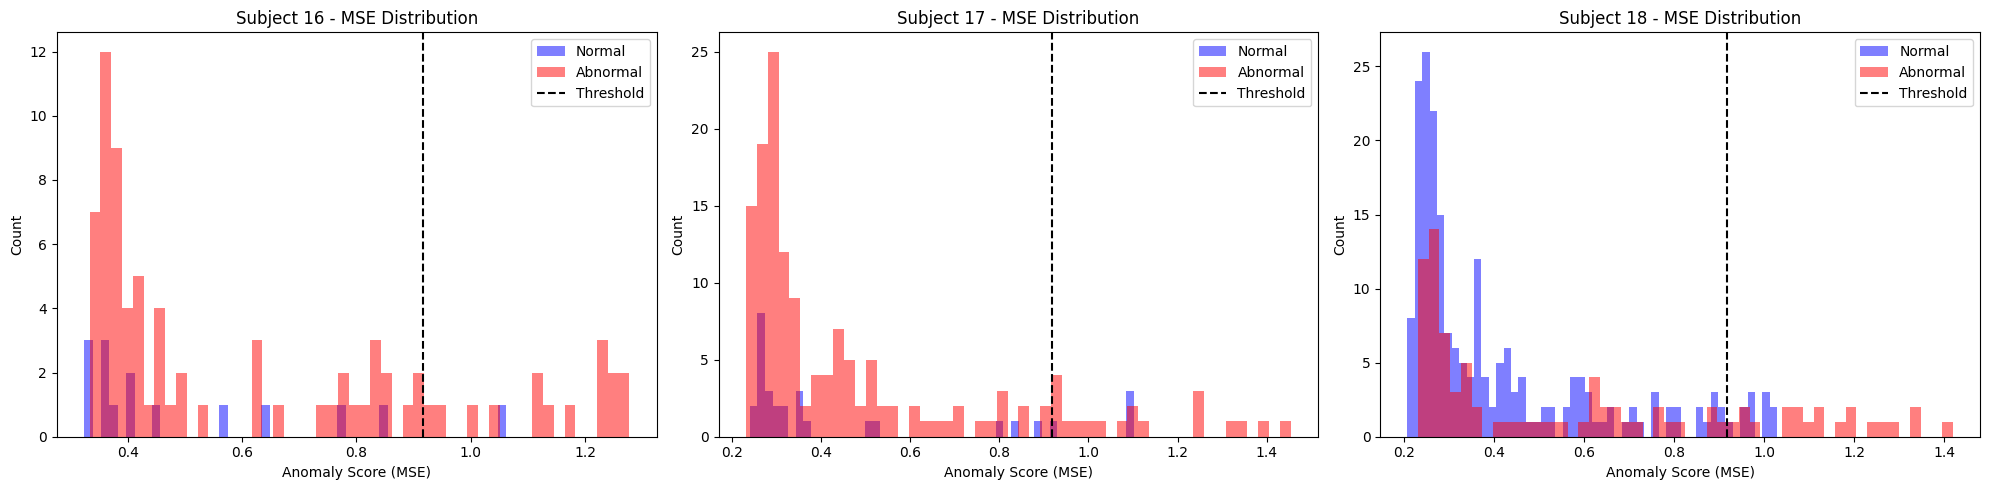

In [49]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
plt.hist(normal_scores_16, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_16, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_16 = np.percentile(normal_scores_16, 95)
plt.axvline(threshold_16, color='black', linestyle='--', label='Threshold')
plt.title('Subject 16 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
plt.hist(normal_scores_17, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_17, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_17 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_17, color='black', linestyle='--', label='Threshold')
plt.title('Subject 17 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
plt.hist(normal_scores_18, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_18, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_18 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_18, color='black', linestyle='--', label='Threshold')
plt.title('Subject 18 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
def create_error_df(normal_scores, abnormal_scores):
    return pd.DataFrame({
        'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
        'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
    })

error_df_16 = create_error_df(normal_scores_16, abnormal_scores_16)
error_df_17 = create_error_df(normal_scores_17, abnormal_scores_17)
error_df_18 = create_error_df(normal_scores_18, abnormal_scores_18)

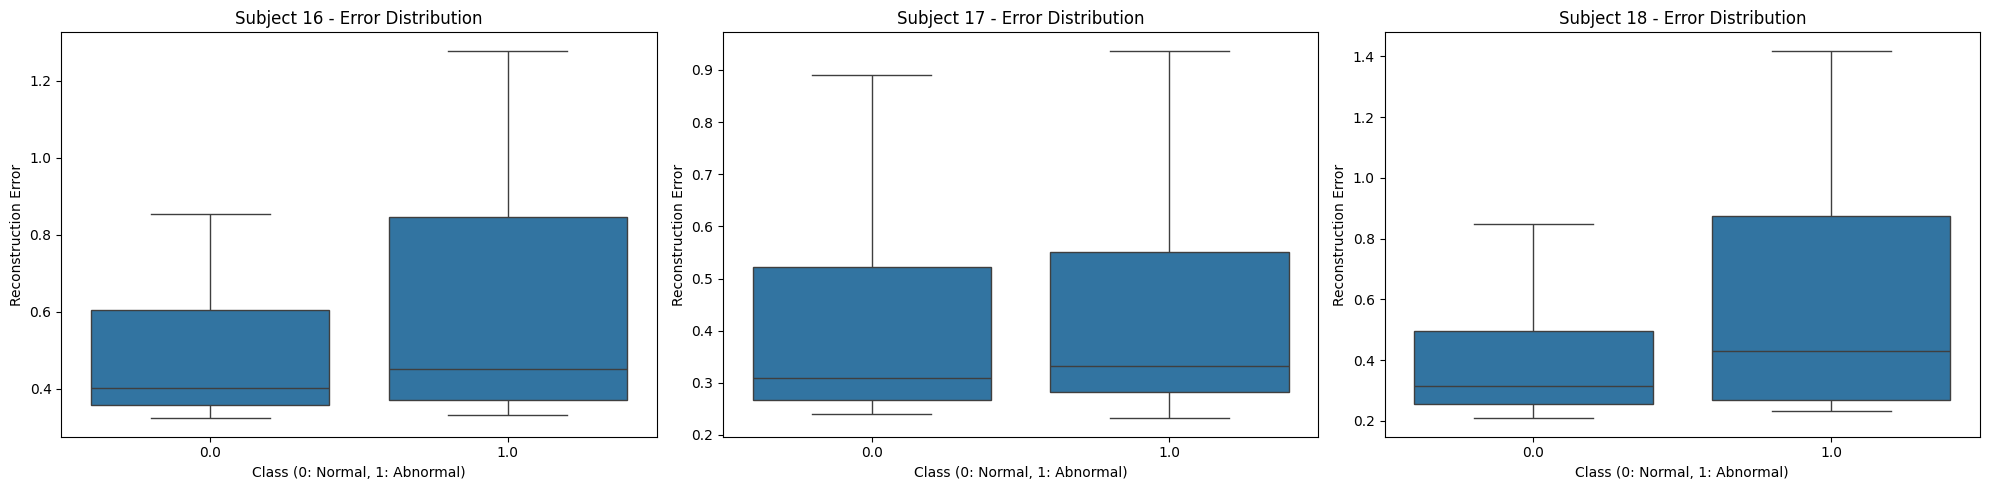

In [51]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_16, showfliers=False)
plt.title('Subject 16 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 2)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_17, showfliers=False)
plt.title('Subject 17 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 3)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_18, showfliers=False)
plt.title('Subject 18 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.tight_layout()
plt.show()

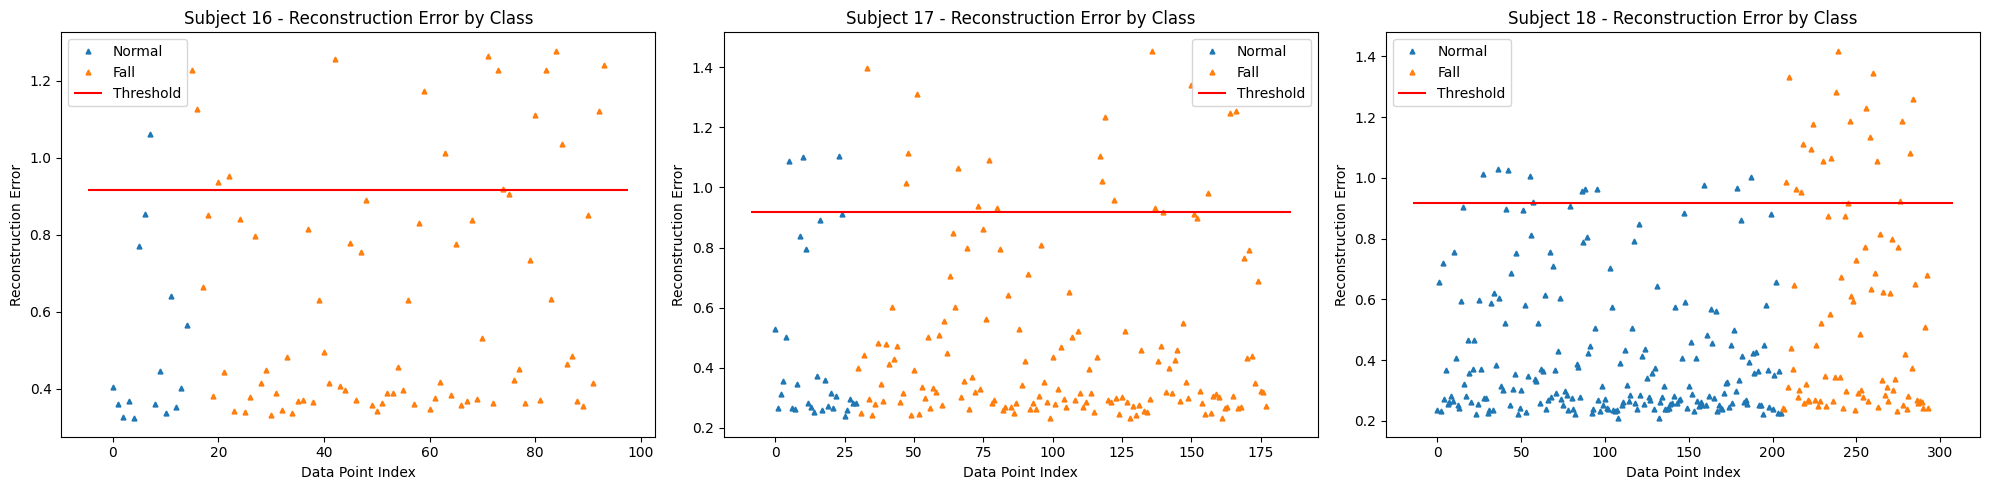

In [52]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
groups = error_df_16.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_16, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 16 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
groups = error_df_17.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_17, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 17 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
groups = error_df_18.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_18, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 18 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

plt.tight_layout()
plt.show()

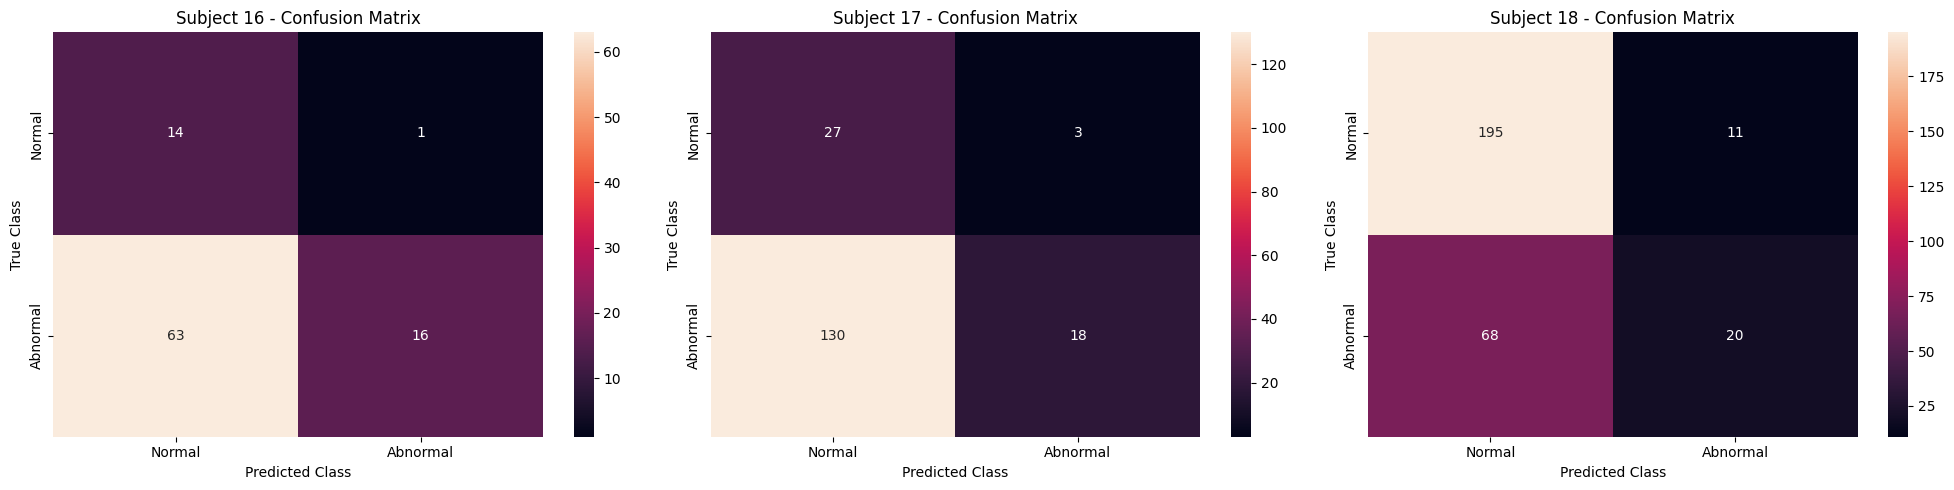

In [53]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
y_pred_16 = [1 if e > threshold_16 else 0 for e in error_df_16.reconstruction_error.values]
conf_matrix_16 = confusion_matrix(error_df_16.true_class, y_pred_16)
sns.heatmap(conf_matrix_16, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 16 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 17
plt.subplot(1, 3, 2)
y_pred_17 = [1 if e > threshold_17 else 0 for e in error_df_17.reconstruction_error.values]
conf_matrix_17 = confusion_matrix(error_df_17.true_class, y_pred_17)
sns.heatmap(conf_matrix_17, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 17 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 18
plt.subplot(1, 3, 3)
y_pred_18 = [1 if e > threshold_18 else 0 for e in error_df_18.reconstruction_error.values]
conf_matrix_18 = confusion_matrix(error_df_18.true_class, y_pred_18)
sns.heatmap(conf_matrix_18, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 18 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

In [54]:
for subject_id, error_df, threshold in [
    (16, error_df_16, threshold_16),
    (17, error_df_17, threshold_17),
    (18, error_df_18, threshold_18)
]:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    y_true = error_df.true_class.values
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'\nSubject {subject_id} Performance:')
    print(f'Accuracy Score : {accuracy:.4f}')
    print(f'Precision     : {precision:.4f}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1 Score      : {f1:.4f}')


Subject 16 Performance:
Accuracy Score : 0.3191
Precision     : 0.9412
Recall        : 0.2025
F1 Score      : 0.3333

Subject 17 Performance:
Accuracy Score : 0.2528
Precision     : 0.8571
Recall        : 0.1216
F1 Score      : 0.2130

Subject 18 Performance:
Accuracy Score : 0.7313
Precision     : 0.6452
Recall        : 0.2273
F1 Score      : 0.3361
